# **Plant Seedling Classification**



### **Context:**
In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

### **Objective:**

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

### **Data Description:**

This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
images.npy
Label.csv

Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.
The goal of the project is to create a classifier capable of determining a plant's species from an image.

List of Plant species

* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common Wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
* Sugar beet  
  













## **Importing the necessary libraries**

In [58]:
import seaborn as sns
import tensorflow as tf
import cv2
import random
import numpy as np
import  matplotlib.pyplot as plt
import pandas as pd
from  tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from  tensorflow.keras.layers import Dense,Flatten,Conv2D, MaxPooling2D, BatchNormalization,Activation,LeakyReLU,Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend
from sklearn.metrics import classification_report, accuracy_score
# Display images using OpenCV
from google.colab.patches import cv2_imshow

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import random
np.random.seed(1) #for numpy
random.seed(1)
tf.random.set_seed(1) #for tensorflow
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Defining Common Functions**

In [59]:
def plot_images(images,labels,rows,cols):
  num_classes=10
  categories=np.unique(labels)
  keys=dict(labels['Label'])

  fig = plt.figure(figsize=(10, 8))
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)
          ax.imshow(images[random_index, :])
          ax.set_title(keys[random_index])
  plt.show()


def clearBackendSetSeeds():
  # Clearing backend & fixing the seed for random number generators
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)






## **Dataset & Summary**

In [60]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/MachineLearning/data_sets/DeepLearningSets/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/MachineLearning/data_sets/DeepLearningSets/Labels.csv')

### **Overview of the dataset**


Let's print the shape of the images and labels

In [61]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## **Exploratory Data Analysis**

### **Plotting Sample Images for Each Class**

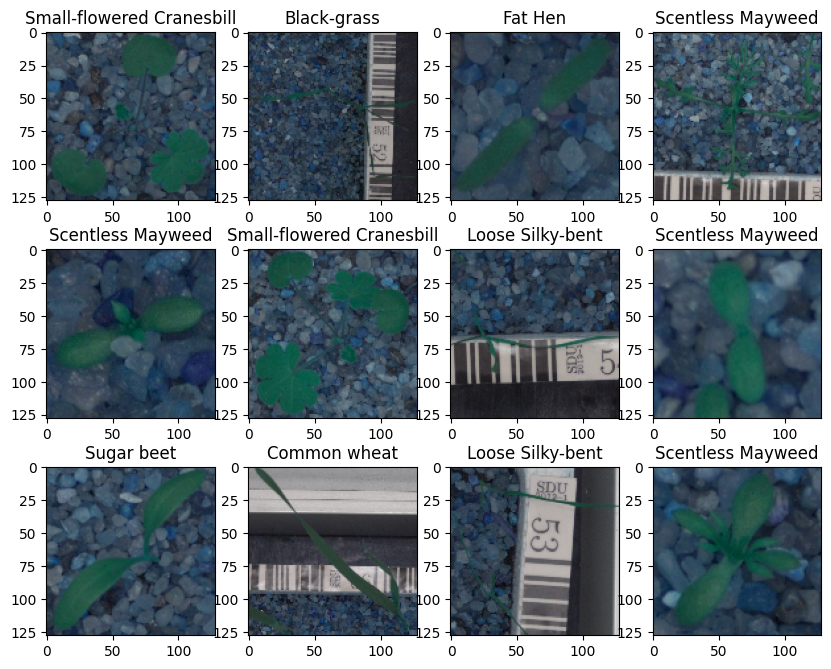

In [62]:
plot_images(images, labels,3,4)

### Count Plot for Each Category

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

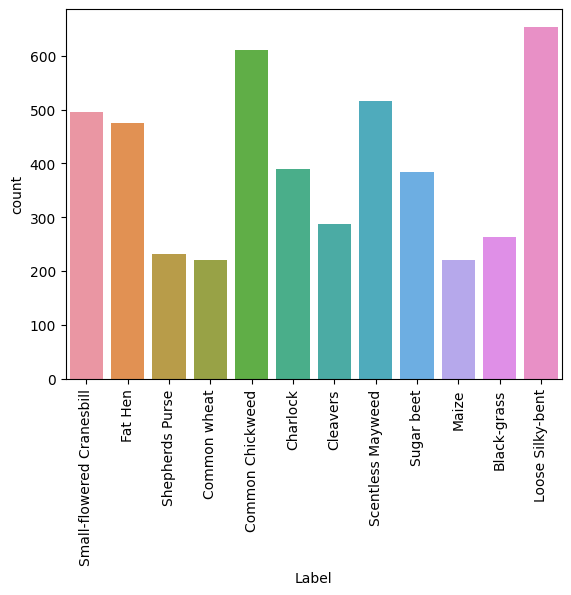

In [63]:
sns.countplot(x=labels['Label'])
plt.xticks(rotation='vertical')

### Dist Plot for Each Category

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Small-flowered Cranesbill'),
  Text(1, 0, 'Fat Hen'),
  Text(2, 0, 'Shepherds Purse'),
  Text(3, 0, 'Common wheat'),
  Text(4, 0, 'Common Chickweed'),
  Text(5, 0, 'Charlock'),
  Text(6, 0, 'Cleavers'),
  Text(7, 0, 'Scentless Mayweed'),
  Text(8, 0, 'Sugar beet'),
  Text(9, 0, 'Maize'),
  Text(10, 0, 'Black-grass'),
  Text(11, 0, 'Loose Silky-bent')])

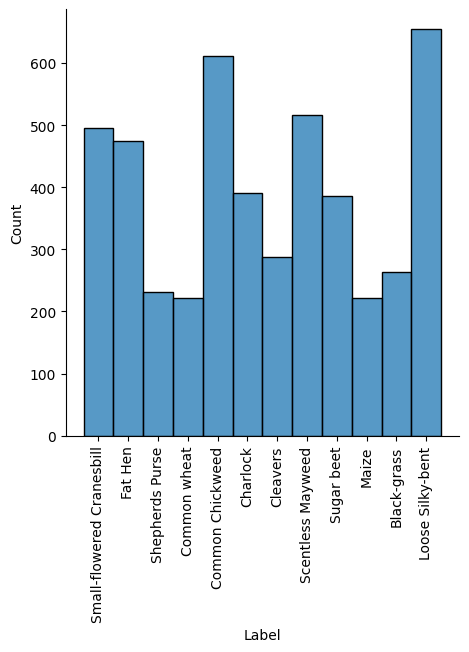

In [64]:
sns.displot(labels['Label'])
plt.xticks(rotation='vertical')

In [65]:
labels.groupby("Label").value_counts()

Label
Black-grass                  263
Charlock                     390
Cleavers                     287
Common Chickweed             611
Common wheat                 221
Fat Hen                      475
Loose Silky-bent             654
Maize                        221
Scentless Mayweed            516
Shepherds Purse              231
Small-flowered Cranesbill    496
Sugar beet                   385
dtype: int64

### EDA Insights

* We observe that the dataset is  imbalanced with different number of images per category
* The loose silky-bent seedling has the highest count in the dataset followed by common chickweed. Both have a count of 654 and 611 respectively
* Shepherds purse, common wheat, cleavers , maize and black grass comprises the lowest count of 231, 221, 287, 221 and 263 respectively


## **Data Preprocessing**

### Preview Images Before Processing

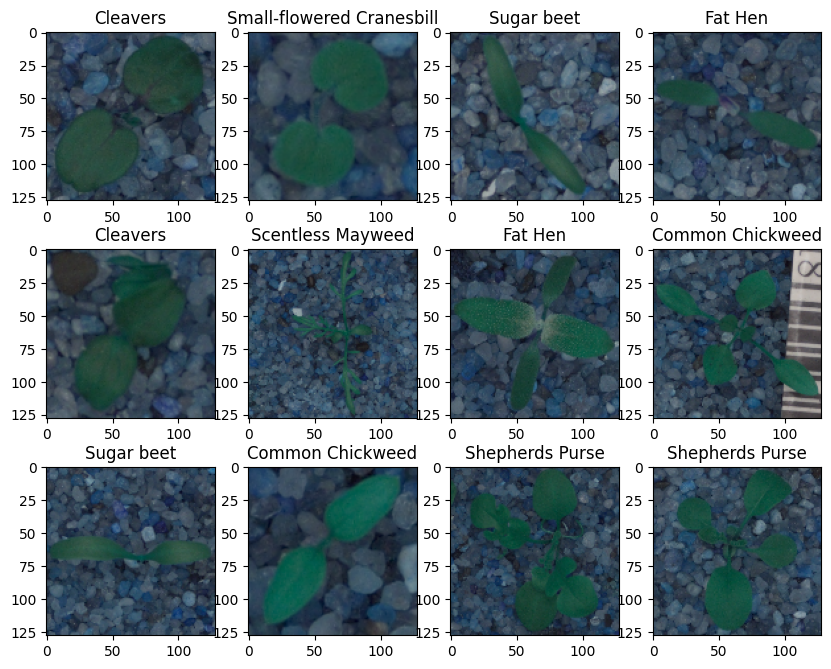

In [66]:
plot_images(images,labels,3,4)

### Plotting sample images using OpenCV and matplotlib

#### Open CV

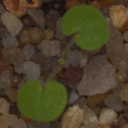

In [67]:
cv2_imshow(images[5])

#### MatplotLib

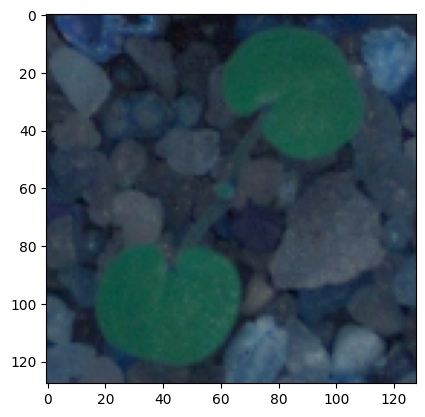

In [68]:
plt.imshow(images[5])

*  The images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV. We need to convert them to standard RGB



#### Convert Images from BGR to RGB

In [69]:
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

#### Confirm Converting Images from BGR to RGB

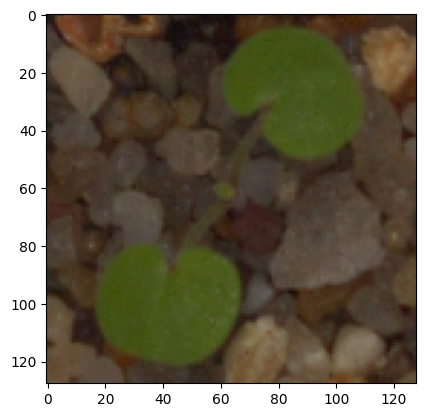

In [70]:
plt.imshow(images[5])

### Applying Gaussian Blur to denoise the images

In [71]:
images_gb=[]
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


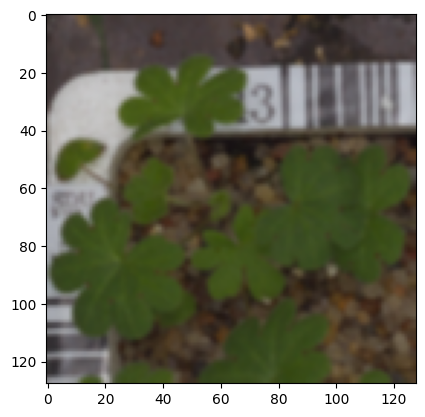

In [72]:
# Confirm with Sample after applying Gaussian Blur
plt.imshow(images_gb[3])

### Preview Images after preprocessing

In [73]:
preprocessed_images =  np.array(images_gb)

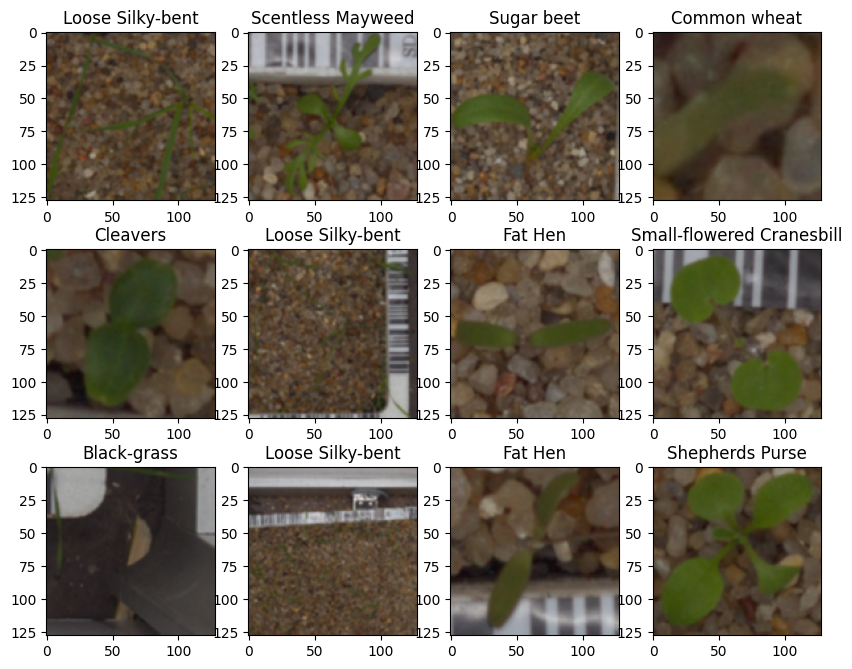

In [74]:
plot_images(preprocessed_images,labels,3,4)

* We observe that the images have less noise after applying various preprocessing techniques
* Some Images might not be easily recongized due to image quality e.g Black-grass and Loose Silky bent. We will dig deeper after model building to evaluate performance

### **Splitting the dataset**

In [75]:
X_temp, X_test, y_temp, y_test = train_test_split(preprocessed_images,labels , test_size=0.3, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.2, random_state=42,stratify=y_temp)

In [76]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(2660, 128, 128, 3) (2660, 1)
(665, 128, 128, 3) (665, 1)
(1425, 128, 128, 3) (1425, 1)


### **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values

### Encoding the target labels

**We will use the labelBinarizer library to hot encode**

In [77]:
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [78]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

## **Model Building - Convolutional Neural Network (CNN)**


In [79]:
clearBackendSetSeeds()

### Model 1

In [80]:
model_1 = Sequential()

model_1.add(Conv2D(128,(3,3), activation="relu",padding="same", input_shape=(128,128,3)))

model_1.add(MaxPooling2D((2,2),padding="same"))

model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))

model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Flatten())

model_1.add(Dense(16, activation='relu'))

model_1.add(Dropout(0.3))

model_1.add(Dense(12, activation='softmax'))

opt=Adam()
model_1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

#### Fitting the model on the train data

In [81]:
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=50,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=100,
            verbose=2
)

Epoch 1/50
27/27 - 5s - loss: 2.4512 - accuracy: 0.1271 - val_loss: 2.3456 - val_accuracy: 0.2301 - 5s/epoch - 188ms/step
Epoch 2/50
27/27 - 3s - loss: 2.2603 - accuracy: 0.2534 - val_loss: 2.0424 - val_accuracy: 0.3338 - 3s/epoch - 106ms/step
Epoch 3/50
27/27 - 3s - loss: 2.1069 - accuracy: 0.3090 - val_loss: 1.9206 - val_accuracy: 0.3970 - 3s/epoch - 103ms/step
Epoch 4/50
27/27 - 3s - loss: 1.9880 - accuracy: 0.3417 - val_loss: 1.8277 - val_accuracy: 0.4271 - 3s/epoch - 105ms/step
Epoch 5/50
27/27 - 3s - loss: 1.9219 - accuracy: 0.3654 - val_loss: 1.7820 - val_accuracy: 0.4211 - 3s/epoch - 101ms/step
Epoch 6/50
27/27 - 3s - loss: 1.8933 - accuracy: 0.3586 - val_loss: 1.7700 - val_accuracy: 0.4286 - 3s/epoch - 105ms/step
Epoch 7/50
27/27 - 3s - loss: 1.8519 - accuracy: 0.3654 - val_loss: 1.7110 - val_accuracy: 0.4526 - 3s/epoch - 107ms/step
Epoch 8/50
27/27 - 3s - loss: 1.7755 - accuracy: 0.3759 - val_loss: 1.6731 - val_accuracy: 0.4632 - 3s/epoch - 106ms/step
Epoch 9/50
27/27 - 3s - 

#### **Model 1 Performance Evaluation**

##### **Accuracy vs Validation**

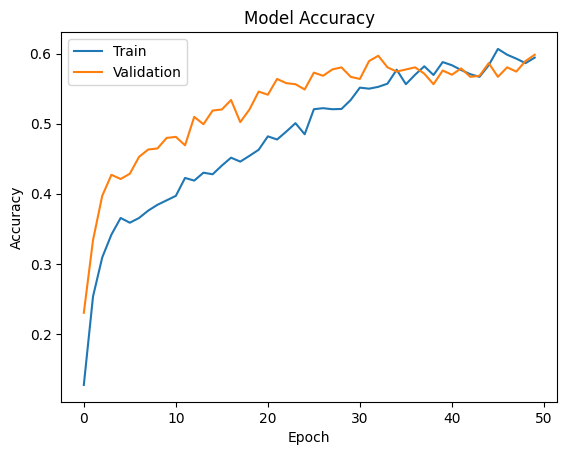

In [82]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### **Model Evaluation on Train Data**

In [83]:
accuracy__train_1 = model_1.evaluate(X_train_normalized, y_train_encoded, verbose=2)

84/84 - 1s - loss: 0.4551 - accuracy: 0.8455 - 910ms/epoch - 11ms/step


##### **Model Evaluation on Validation Data**

In [84]:
accuracy__val_1 = model_1.evaluate(X_val_normalized, y_val_encoded, verbose=2)

21/21 - 0s - loss: 1.5754 - accuracy: 0.5985 - 246ms/epoch - 12ms/step


##### **Model Evaluation on Test Data**

In [85]:
accuracy_1 = model_1.evaluate(X_test_normalized, y_test_encoded, verbose=2)

45/45 - 0s - loss: 1.5991 - accuracy: 0.5902 - 470ms/epoch - 10ms/step


##### **Predictions from Test Data**

In [86]:
y_pred=model_1.predict(X_test_normalized)

45/45 [==============================] - 0s 9ms/step


In [87]:
y_pred

array([[3.2614296e-06, 2.6258526e-02, 5.9612739e-01, ..., 4.3730382e-02,
        1.1761351e-01, 4.4161454e-03],
       [1.9959962e-01, 1.0480054e-03, 2.4997971e-03, ..., 5.1237064e-05,
        3.0694704e-05, 3.9468883e-04],
       [1.6975824e-14, 6.0248062e-02, 1.9506608e-04, ..., 6.4875484e-02,
        8.6132193e-01, 3.0096948e-05],
       ...,
       [2.8888833e-19, 2.7055442e-02, 2.3850546e-07, ..., 4.3117080e-02,
        9.2931986e-01, 5.1100010e-08],
       [4.1591164e-05, 2.3922822e-01, 2.2439896e-01, ..., 8.7183580e-02,
        3.6440525e-04, 1.9679159e-02],
       [3.1218715e-08, 4.0660372e-01, 1.9506451e-02, ..., 3.1590259e-01,
        1.8578129e-01, 4.0695360e-03]], dtype=float32)

##### **Confusion Matrix**


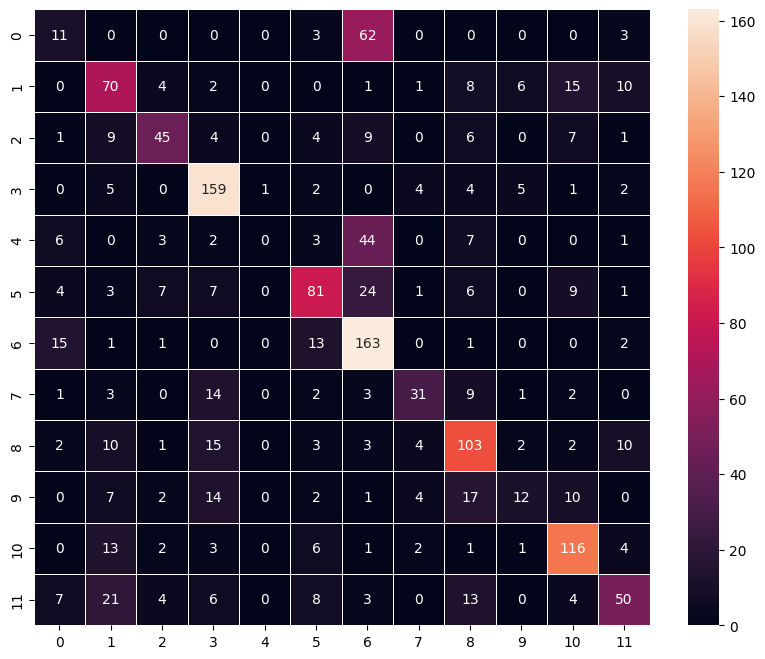

In [88]:
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

##### **Classification Report**


In [89]:
print(classification_report(y_test_arg,y_pred_arg))

              precision    recall  f1-score   support

           0       0.23      0.14      0.17        79
           1       0.49      0.60      0.54       117
           2       0.65      0.52      0.58        86
           3       0.70      0.87      0.78       183
           4       0.00      0.00      0.00        66
           5       0.64      0.57      0.60       143
           6       0.52      0.83      0.64       196
           7       0.66      0.47      0.55        66
           8       0.59      0.66      0.62       155
           9       0.44      0.17      0.25        69
          10       0.70      0.78      0.74       149
          11       0.60      0.43      0.50       116

    accuracy                           0.59      1425
   macro avg       0.52      0.50      0.50      1425
weighted avg       0.56      0.59      0.56      1425



##### **Observations**
*   **In terms of accuracy the model perfoms well on the validation dataset than on the training set**
*   However, the model does not perform well on the testing dataset.
* This could point to over fitting
* We observe that some of the classes are not predicted properly
* Classes 3,5,6,8,10 are well classified
* Classes 0,1,2,4,7,9,11 are mostly misclassified with poor performance on recall on each

### Model Improvement Suggestions



*  From previous observations, we observe that the model has a low accuracy of  48% on test/unseen data
*  We will try various techniques like data augmentation, Batch Normalization, Drop out and early stopping to check if we can improve the performance
* We will also build a model using Transfer learning to check if we can have a  better performance







### Model 2 - Data Augmentation with Early Stopping, Batch Normalization, Drop out layers

In [90]:
clearBackendSetSeeds()

In [91]:
# rescale all images
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

**Creating a new model 2 with Batch Normalization, Early Stopping & Drop out layer**

In [92]:
model_2 = Sequential()
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(BatchNormalization())
model_2.add(Flatten())
model_2.add(Dense(16, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(12, activation='softmax'))
opt=Adam()
model_2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                        

**Fitting the model and applying data augmentation**

In [93]:
epochs = 50
batch_size = 100
history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
26/26 [==============================] - 13s 425ms/step - loss: 2.3455 - accuracy: 0.1461 - val_loss: 2.4837 - val_accuracy: 0.0872
Epoch 2/50
26/26 [==============================] - 11s 406ms/step - loss: 2.0073 - accuracy: 0.2770 - val_loss: 2.3648 - val_accuracy: 0.2090
Epoch 3/50
26/26 [==============================] - 17s 648ms/step - loss: 1.8478 - accuracy: 0.3133 - val_loss: 2.4052 - val_accuracy: 0.1023
Epoch 4/50
26/26 [==============================] - 13s 493ms/step - loss: 1.7138 - accuracy: 0.3922 - val_loss: 2.3550 - val_accuracy: 0.3158
Epoch 5/50
26/26 [==============================] - 10s 395ms/step - loss: 1.5817 - accuracy: 0.4457 - val_loss: 2.2778 - val_accuracy: 0.2752
Epoch 6/50
26/26 [==============================] - 9s 347ms/step - loss: 1.4464 - accuracy: 0.4684 - val_loss: 2.1511 - val_accuracy: 0.3023
Epoch 7/50
26/26 [==============================] - 11s 397ms/step - loss: 1.3609 - accuracy: 0.5000 - val_loss: 2.1767 - val_accuracy: 0.2331


#### **Model 2 Performance Evaluation**

##### **Accuracy vs Validation**

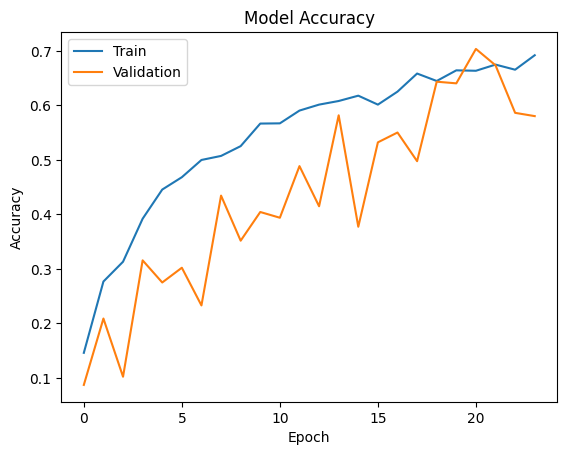

In [94]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### **Model Evaluation on Train Data**

In [95]:
accuracy__train_2 = model_2.evaluate(X_train_normalized, y_train_encoded, verbose=2)

84/84 - 1s - loss: 0.6675 - accuracy: 0.8293 - 601ms/epoch - 7ms/step


##### **Model Evaluation on Validation Data**

In [96]:
accuracy__val_2 = model_2.evaluate(X_val_normalized, y_val_encoded, verbose=2)

21/21 - 0s - loss: 1.0094 - accuracy: 0.7038 - 262ms/epoch - 12ms/step


##### **Model Evaluation on Test Data**

In [97]:
accuracy_2 = model_2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

45/45 - 0s - loss: 0.9610 - accuracy: 0.6989 - 315ms/epoch - 7ms/step


##### **Predictions from Test Data**

In [98]:
y_pred2=model_2.predict(X_test_normalized)

45/45 [==============================] - 0s 6ms/step


##### **Confusion Matrix**

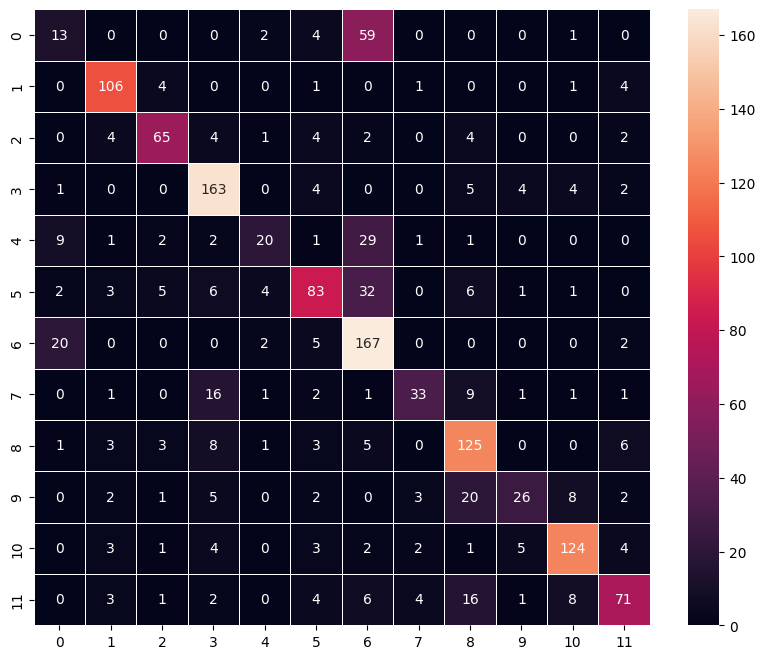

In [99]:
y_pred_arg2=np.argmax(y_pred2,axis=1)
y_test_arg2=np.argmax(y_test_encoded,axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test_arg2,y_pred_arg2)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

##### **Classification Report**


In [100]:
print(classification_report(y_test_arg2,y_pred_arg2))

              precision    recall  f1-score   support

           0       0.28      0.16      0.21        79
           1       0.84      0.91      0.87       117
           2       0.79      0.76      0.77        86
           3       0.78      0.89      0.83       183
           4       0.65      0.30      0.41        66
           5       0.72      0.58      0.64       143
           6       0.55      0.85      0.67       196
           7       0.75      0.50      0.60        66
           8       0.67      0.81      0.73       155
           9       0.68      0.38      0.49        69
          10       0.84      0.83      0.84       149
          11       0.76      0.61      0.68       116

    accuracy                           0.70      1425
   macro avg       0.69      0.63      0.64      1425
weighted avg       0.70      0.70      0.69      1425



##### **Observation**
*   **Model 2 accuracy has improved and is better compared to model 1**
*   The model gives a better accuracy on the test dataset compared to model 1 accuracy
* We observe spikes in the validation dataset. It does not give a generalized performance on the validation dataset.
* Classification has also improved compared to previous. Classes 1,2,3,5,6,8,10,11 are well classified
* We however observe misclassification with classes 0, 4, 7, 9

### Model 3 - Transfer Learning using VGG16

In [101]:
clearBackendSetSeeds()

In [102]:
vgg_model_3 = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3))
vgg_model_3.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [103]:
## Make all layers non trainable
for layer in vgg_model_3.layers:
    layer.trainable = False

In [104]:
model_3 = Sequential()
model_3.add(vgg_model_3)
model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(12, activation='softmax'))
opt=Adam()
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                396       
                                                                 
Total params: 14,977,260
Trainable params: 262,572
Non-trainable params: 14,714,688
_________________________________________________________________


In [105]:
history_vgg16_model_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=50,
                    steps_per_epoch=X_train_normalized.shape[0] // 100,
                    validation_data=(X_val_normalized,y_val_encoded),callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
26/26 [==============================] - 14s 497ms/step - loss: 2.4224 - accuracy: 0.1531 - val_loss: 2.2612 - val_accuracy: 0.2391
Epoch 2/50
26/26 [==============================] - 12s 450ms/step - loss: 2.1968 - accuracy: 0.2789 - val_loss: 2.0964 - val_accuracy: 0.3624
Epoch 3/50
26/26 [==============================] - 11s 422ms/step - loss: 2.0639 - accuracy: 0.3082 - val_loss: 1.9745 - val_accuracy: 0.3940
Epoch 4/50
26/26 [==============================] - 12s 454ms/step - loss: 1.9400 - accuracy: 0.3546 - val_loss: 1.8492 - val_accuracy: 0.4090
Epoch 5/50
26/26 [==============================] - 12s 461ms/step - loss: 1.8354 - accuracy: 0.3773 - val_loss: 1.7648 - val_accuracy: 0.4571
Epoch 6/50
26/26 [==============================] - 12s 485ms/step - loss: 1.7851 - accuracy: 0.3922 - val_loss: 1.7232 - val_accuracy: 0.4947
Epoch 7/50
26/26 [==============================] - 12s 478ms/step - loss: 1.7107 - accuracy: 0.4246 - val_loss: 1.6294 - val_accuracy: 0.5038

##### **Model 3 Performance Evaluation**

##### **Accuracy vs Validation**

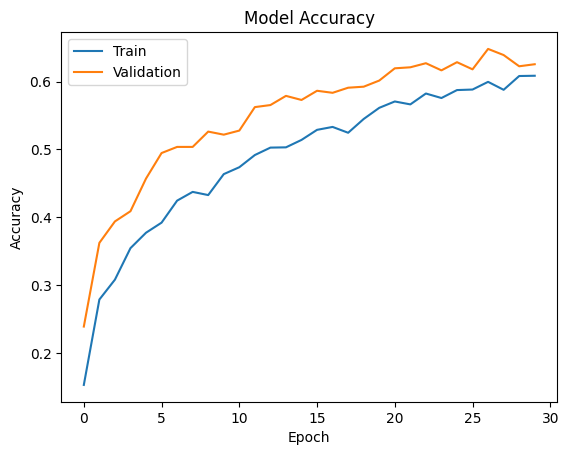

In [106]:
plt.plot(history_vgg16_model_3.history['accuracy'])
plt.plot(history_vgg16_model_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##### **Model Evaluation on Train Data**

In [107]:
accuracy__train_3 = model_3.evaluate(X_train_normalized, y_train_encoded, verbose=2)

84/84 - 4s - loss: 0.8094 - accuracy: 0.7673 - 4s/epoch - 42ms/step


##### **Model Evaluation on Validation Data**

In [108]:
accuracy__val_3 = model_3.evaluate(X_val_normalized, y_val_encoded, verbose=2)

21/21 - 1s - loss: 1.1257 - accuracy: 0.6481 - 901ms/epoch - 43ms/step


##### **Model Evaluation on Test Data**

In [109]:
accuracy_3 = model_3.evaluate(X_test_normalized, y_test_encoded, verbose=2)

45/45 - 2s - loss: 1.1222 - accuracy: 0.6288 - 2s/epoch - 43ms/step


##### **Predictions from Test Data**

In [110]:
y_pred_3 = y_pred2=model_3.predict(X_test_normalized)u

45/45 [==============================] - 2s 43ms/step


##### **Confusion Matrix**

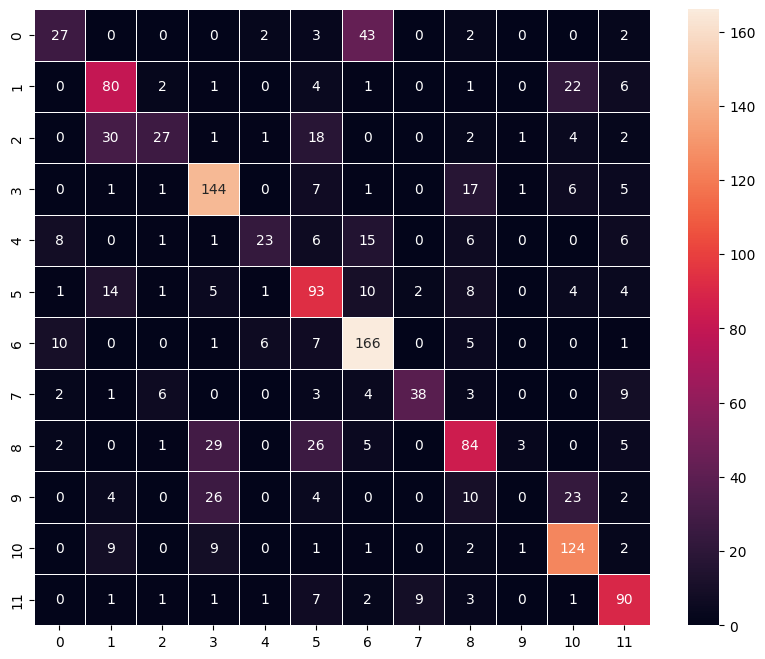

In [111]:
y_pred_arg3=np.argmax(y_pred_3,axis=1)
y_test_arg3=np.argmax(y_test_encoded,axis=1)
confusion_matrix = tf.math.confusion_matrix(y_test_arg3,y_pred_arg3)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

##### **Classification Report**


In [112]:
print(classification_report(y_test_arg3,y_pred_arg3))

              precision    recall  f1-score   support

           0       0.54      0.34      0.42        79
           1       0.57      0.68      0.62       117
           2       0.68      0.31      0.43        86
           3       0.66      0.79      0.72       183
           4       0.68      0.35      0.46        66
           5       0.52      0.65      0.58       143
           6       0.67      0.85      0.75       196
           7       0.78      0.58      0.66        66
           8       0.59      0.54      0.56       155
           9       0.00      0.00      0.00        69
          10       0.67      0.83      0.74       149
          11       0.67      0.78      0.72       116

    accuracy                           0.63      1425
   macro avg       0.59      0.56      0.56      1425
weighted avg       0.60      0.63      0.60      1425



##### **Observation**
* The model gives a generalized performance on both training and validation sets compared to model 2.
* We however still observe misclassification with classes 0, 2, 4, 7, 9 but recall on classes 0,4 has improved compared to other models

### **Model Comparision & Results**

In [113]:
pd.DataFrame({'Models':['Model 1','Model 2 ','Model 3'],'Train Accuracy':[round(accuracy__train_1[1]*100,2)  ,round(accuracy__train_2[1]*100,2),round(accuracy__train_3[1]*100,2)],'Validation Accuracy':[round(accuracy__val_1[1]*100,2),round(accuracy__val_2[1]*100,2),round(accuracy__val_3[1]*100,2)],'Test Accuracy':[round(accuracy_1[1]*100,2),round(accuracy_2[1]*100,2),round(accuracy_3[1]*100,2)]})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Model 1,84.55,59.85,59.02
1,Model 2,82.93,70.38,69.89
2,Model 3,76.73,64.81,62.88


## **Conclusion & Key Takeways**
* We have built 3 different models , and model 3 is the best performing on test data with 69% accuracy
* Model 3, gives a more generalized perfomance
* All models perform well on train data set but slightly poorly on the test datasets. There is slight overfitting
* Data augmentation, Early stopping, Batch Normalization & Drop out Layers have helped to improve the model performance
* Transfer learning has helped improve the performance and also reduced the computational expense and given a better performance than the base CNN model
* Models can be further improved by different filter sizes and number of filters
* Other transfer learning models/architectures can be employed to further train the CNN Models
